In [1]:
import os

import numpy as np
import importlib
import gymnasium as gym
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.animation as manimation

import gym_env
from models import LinearRL_NHB, SR_NHB
from utils import policy_reval, woodbury
from utils_render import plot_nhb_decisions, create_bar_plot, plot_decision_prob

In [2]:
# Set the random seed for NumPy
seed = 42
np.random.seed(42)

# Save dir
save_dir = os.path.join('..', 'figures/')

In [3]:
# For plotting
prob_locs = [1, 2]
colors = [3, 2]

In [5]:
## Hyperparameters for individual plots to make results more similar to NHB
# lambd = 10
# alpha = 0.1
# alpha_SR = 0.2
# beta = 0.9
# num_steps = 115
# num_iterations = 400

## Hyperparameters for plots all together to show a regular agent
lambd = 10
alpha = 0.15
alpha_SR = 0.15
beta = 1.0
num_steps = 250
num_iterations = 400

# Policy Revaluation

## Run Simulations

### Complete Model

In [6]:
choices_complete = {"train":np.array([0,0]), "test":np.array([0,0])}
for i in range(num_iterations):
    # Define agent
    agent_complete =  LinearRL_NHB(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=True, exp_type="policy_reval")
    # Get optimal DR and update V and Z Values
    D_inv = agent_complete.get_D_inv()
    agent_complete.DR = D_inv
    agent_complete.update_Z()
    agent_complete.update_V()
    dec_train = np.argmax([agent_complete.V[1], agent_complete.V[2]])
    choices_complete["train"][dec_train] += 1

    # Update terminal state values
    agent_complete.update_exp()
    V_new, Z_new = policy_reval(agent_complete)
    dec_test = np.argmax([V_new[1], V_new[2]])
    choices_complete["test"][dec_test] += 1

### TD Models

In [7]:
choices_with = {"train":np.array([0,0]), "test":np.array([0,0])}
choices_without = {"train":np.array([0,0]), "test":np.array([0,0])}
choices_sr = {"train":np.array([0,0]), "test":np.array([0,0])}

for i in range(num_iterations):
    # Define agents
    agent_with_imp = LinearRL_NHB(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=True, exp_type="policy_reval")
    agent_without_imp = LinearRL_NHB(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=False, exp_type="policy_reval")
    agent_SR = SR_NHB(alpha=alpha_SR, beta=10.0, num_steps=num_steps, policy="softmax", exp_type="policy_reval")

    # Have the agents learn the environment
    agent_with_imp.learn(seed=i)
    agent_without_imp.learn(seed=i)
    agent_SR.learn(seed=i)
    
    ## SR
    # Original training policy
    dec_train = np.argmax([agent_SR.V[1], agent_SR.V[2]])
    choices_sr["train"][dec_train] += 1
    # Policy revaluation
    agent_SR.update_exp()
    agent_SR.update_V()
    # New policy
    dec_test = np.argmax([agent_SR.V[1], agent_SR.V[2]])
    choices_sr["test"][dec_test] += 1


    ## With importance sampling
    # Original training policy
    dec_train = np.argmax([agent_with_imp.V[1], agent_with_imp.V[2]])
    choices_with["train"][dec_train] += 1
    # Policy revaluation
    agent_with_imp.update_exp()
    V_new, Z_new = policy_reval(agent_with_imp)
    # New policy
    dec_test = np.argmax([V_new[1], V_new[2]])
    choices_with["test"][dec_test] += 1

    ## Without importance sampling
    # Original training policy
    dec_train = np.argmax([agent_without_imp.V[1], agent_without_imp.V[2]])
    choices_without["train"][dec_train] += 1
    # Policy revaluation
    agent_without_imp.update_exp()
    V_new, Z_new = policy_reval(agent_without_imp)
    # New policy
    dec_test = np.argmax([V_new[1], V_new[2]])
    choices_without["test"][dec_test] += 1


In [8]:
print(choices_with["train"])
print(f"selected state 1: {choices_with['test'][0]/num_iterations}\n")
print(choices_without)
print(f"selected state 1: {choices_without['test'][0]/num_iterations}")

[  0 400]
selected state 1: 0.755

{'train': array([  1, 399]), 'test': array([182, 218])}
selected state 1: 0.455


## Action Selection Probs

### Complete

In [9]:
prob_policy_complete = choices_complete["test"] / num_iterations
p_comp = choices_complete["test"][1] / num_iterations
std_policy_complete = np.sqrt((p_comp * (1 - p_comp)) / num_iterations)

### SR

In [10]:
prob_policy_sr = choices_sr["test"] / num_iterations
p_sr = choices_sr["test"][1] / num_iterations
std_policy_sr = np.sqrt((p_sr * (1 - p_sr)) / num_iterations)

### With Importance Sampling

In [11]:
# Train
prob_policy_with_train = choices_with["train"] / num_iterations

p_train = choices_with["train"][1] / num_iterations
std_policy_with_train = np.sqrt((p_train * (1 - p_train)) / num_iterations)

# Test
prob_policy_with = choices_with["test"] / num_iterations

p_test = choices_with["test"][1] / num_iterations
std_policy_with = np.sqrt((p_test * (1 - p_test)) / num_iterations)

### Without Importance Sampling

In [12]:
# Train
prob_policy_without_train = choices_without["train"] / num_iterations

p_train = choices_without["train"][1] / num_iterations
std_policy_without_train = np.sqrt((p_train * (1 - p_train)) / num_iterations)

# Test
prob_policy_without = choices_without["test"] / num_iterations

p_test = choices_without["test"][1] / num_iterations
std_policy_without = np.sqrt((p_test * (1 - p_test)) / num_iterations)

# Reward Revaluation

## Run Simulations

### Complete Model

In [13]:
choices_complete = {"train":np.array([0,0]), "test":np.array([0,0])}
for i in range(num_iterations):
    # Define agent
    agent_complete =  LinearRL_NHB(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=True, exp_type="reward_reval")
    # Get optimal DR and update V and Z Values
    D_inv = agent_complete.get_D_inv()
    agent_complete.DR = D_inv
    agent_complete.update_Z()
    agent_complete.update_V()
    dec_train = np.argmax([agent_complete.V[1], agent_complete.V[2]])
    choices_complete["train"][dec_train] += 1

    # Update terminal state values
    agent_complete.update_exp()
    V_new, Z_new = policy_reval(agent_complete)
    dec_test = np.argmax([V_new[1], V_new[2]])
    choices_complete["test"][dec_test] += 1

### TD Models

In [14]:
choices_with = {"train":np.array([0,0]), "test":np.array([0,0])}
choices_without = {"train":np.array([0,0]), "test":np.array([0,0])}
choices_sr = {"train":np.array([0,0]), "test":np.array([0,0])}

for i in range(num_iterations):
    # Define agents
    agent_with_imp = LinearRL_NHB(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=True, exp_type="reward_reval")
    agent_without_imp = LinearRL_NHB(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=False, exp_type="reward_reval")
    agent_SR = SR_NHB(alpha=alpha_SR, beta=10.0, num_steps=num_steps, policy="softmax", exp_type="reward_reval")

    # Have the agents learn the environment
    agent_with_imp.learn(seed=i)
    agent_without_imp.learn(seed=i)
    agent_SR.learn(seed=i)

    ## SR
    # Original training policy
    dec_train = np.argmax([agent_SR.V[1], agent_SR.V[2]])
    choices_sr["train"][dec_train] += 1
    # Policy revaluation
    agent_SR.update_exp()
    agent_SR.update_V()
    # New policy
    dec_test = np.argmax([agent_SR.V[1], agent_SR.V[2]])
    choices_sr["test"][dec_test] += 1
    
    ## With importance sampling
    # Original training policy
    dec_train = np.argmax([agent_with_imp.V[1], agent_with_imp.V[2]])
    choices_with["train"][dec_train] += 1
    # Policy revaluation
    agent_with_imp.update_exp()
    V_new, Z_new = policy_reval(agent_with_imp)
    # New policy
    dec_test = np.argmax([V_new[1], V_new[2]])
    choices_with["test"][dec_test] += 1

    ## Without importance sampling
    # Original training policy
    dec_train = np.argmax([agent_without_imp.V[1], agent_without_imp.V[2]])
    choices_without["train"][dec_train] += 1
    # Policy revaluation
    agent_without_imp.update_exp()
    V_new, Z_new = policy_reval(agent_without_imp)
    # New policy
    dec_test = np.argmax([V_new[1], V_new[2]])
    choices_without["test"][dec_test] += 1

In [15]:
print(choices_with["train"])
print(f"selected state 1: {choices_with['test'][0]/num_iterations}\n")
print(choices_without)
print(f"selected state 1: {choices_without['test'][0]/num_iterations}")

[  0 400]
selected state 1: 0.9025

{'train': array([  0, 400]), 'test': array([308,  92])}
selected state 1: 0.77


## Action Selection Probs

### Complete

In [16]:
prob_reward_complete = choices_complete["test"] / num_iterations
p_comp = choices_complete["test"][1] / num_iterations
std_reward_complete = np.sqrt((p_comp * (1 - p_comp)) / num_iterations)

### SR

In [17]:
prob_reward_sr = choices_sr["test"] / num_iterations
p_sr = choices_sr["test"][1] / num_iterations
std_reward_sr = np.sqrt((p_sr * (1 - p_sr)) / num_iterations)

### With Importance Sampling

In [18]:
# Train
prob_reward_with_train = choices_with["train"] / num_iterations

p_train = choices_with["train"][1] / num_iterations
std_reward_with_train = np.sqrt((p_train * (1 - p_train)) / num_iterations)

# Test
prob_reward_with = choices_with["test"] / num_iterations

p_test = choices_with["test"][1] / num_iterations
std_reward_with = np.sqrt((p_test * (1 - p_test)) / num_iterations)

### Without Importance Sampling

In [19]:
# Train
prob_reward_without_train = choices_without["train"] / num_iterations

p_train = choices_without["train"][1] / num_iterations
std_reward_without_train = np.sqrt((p_train * (1 - p_train)) / num_iterations)

# Test
prob_reward_without = choices_without["test"] / num_iterations

p_test = choices_without["test"][1] / num_iterations
std_reward_without = np.sqrt((p_test * (1 - p_test)) / num_iterations)

# Transition Revaluation

## Run Simulations

In [21]:
choices_with = {"train":np.array([0,0]), "test":np.array([0,0])}
choices_without = {"train":np.array([0,0]), "test":np.array([0,0])}

for i in range(num_iterations):
    # Define agents
    agent_with_imp = LinearRL_NHB(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=True, exp_type="trans_reval")
    agent_without_imp = LinearRL_NHB(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=False, exp_type="trans_reval")

    # Have the agents learn the environment
    agent_with_imp.learn(seed=i)
    agent_without_imp.learn(seed=i)

    ## With importance sampling
    # Original training policy
    dec_train = np.argmax([agent_with_imp.V[1], agent_with_imp.V[2]])
    choices_with["train"][dec_train] += 1

    # Transition revaluation
    T_new = agent_with_imp.construct_T_new()
    D_new = woodbury(agent=agent_with_imp, T=T_new, inv=False)
    agent_with_imp.DR = D_new
    agent_with_imp.update_Z()
    agent_with_imp.update_V()
    V_new = agent_with_imp.V

    # New policy
    dec_test = np.argmax([V_new[1], V_new[2]])
    choices_with["test"][dec_test] += 1

    ## Without importance sampling
    # Original training task
    dec_train = np.argmax([agent_without_imp.V[1], agent_without_imp.V[2]])
    choices_without["train"][dec_train] += 1

    # Transition revaluation
    T_new = agent_without_imp.construct_T_new()
    D_new = woodbury(agent=agent_without_imp, T=T_new, inv=False)
    agent_without_imp.DR = D_new
    agent_without_imp.update_Z()
    agent_without_imp.update_V()
    V_new = agent_without_imp.V

    # New policy
    dec_test = np.argmax([V_new[1], V_new[2]])
    choices_without["test"][dec_test] += 1

In [22]:
print(choices_with["train"])
print(f"selected state 1: {choices_with['test'][0]/num_iterations}\n")
print(choices_without)
print(f"selected state 1: {choices_without['test'][0]/num_iterations}")

[  0 400]
selected state 1: 0.7625

{'train': array([  0, 400]), 'test': array([110, 290])}
selected state 1: 0.275


## Action Selection Probs

### With Importance Sampling

In [23]:
# Train
prob_transition_with_train = choices_with["train"] / num_iterations

p_train = choices_with["train"][1] / num_iterations
std_transition_with_train = np.sqrt((p_train * (1 - p_train)) / num_iterations)

# Test
prob_transition_with = choices_with["test"] / num_iterations

p_test = choices_with["test"][1] / num_iterations
std_transition_with = np.sqrt((p_test * (1 - p_test)) / num_iterations)

### Without Importance Sampling

In [24]:
# Train
prob_transition_without_train = choices_without["train"] / num_iterations

p_train = choices_without["train"][1] / num_iterations
std_transition_without_train = np.sqrt((p_train * (1 - p_train)) / num_iterations)

# Test
prob_transition_without = choices_without["test"] / num_iterations

p_test = choices_without["test"][1] / num_iterations
std_transition_without = np.sqrt((p_test * (1 - p_test)) / num_iterations)

# Plot Simulation Results

## With Importance Sampling

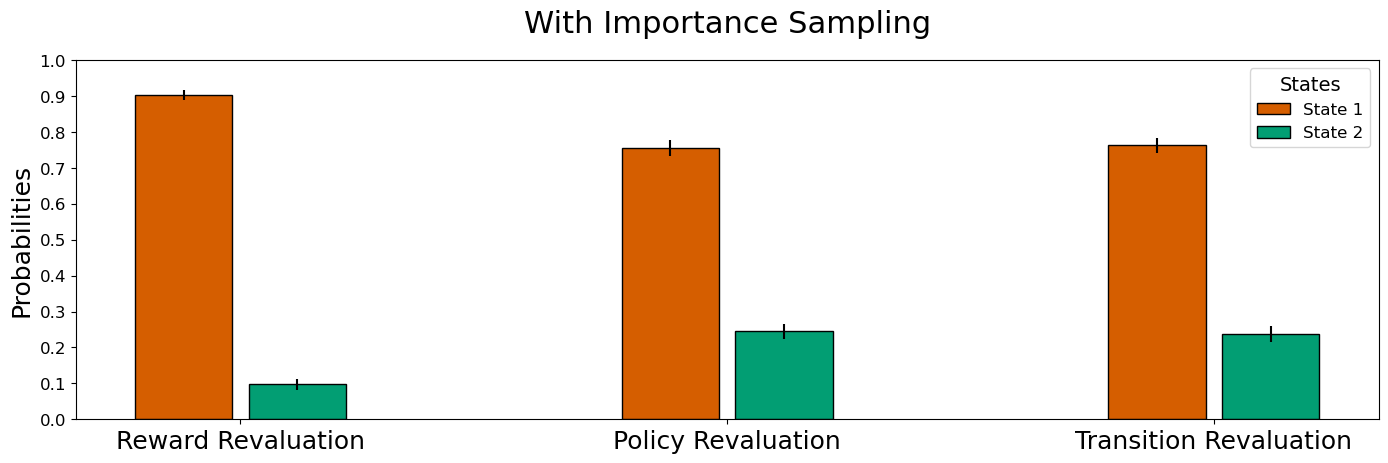

In [25]:
# save_path = save_dir + "nhb_simulations_with.png"
save_path = None

plot_nhb_decisions(
    probs_reward=prob_reward_with,
    probs_policy=prob_policy_with,
    probs_transition=prob_transition_with,
    colors=colors,
    leg_loc='upper right',
    save_path=save_path,
    title='With Importance Sampling',
    std=[std_reward_with, std_policy_with, std_transition_with]
)

## Without Importance Sampling

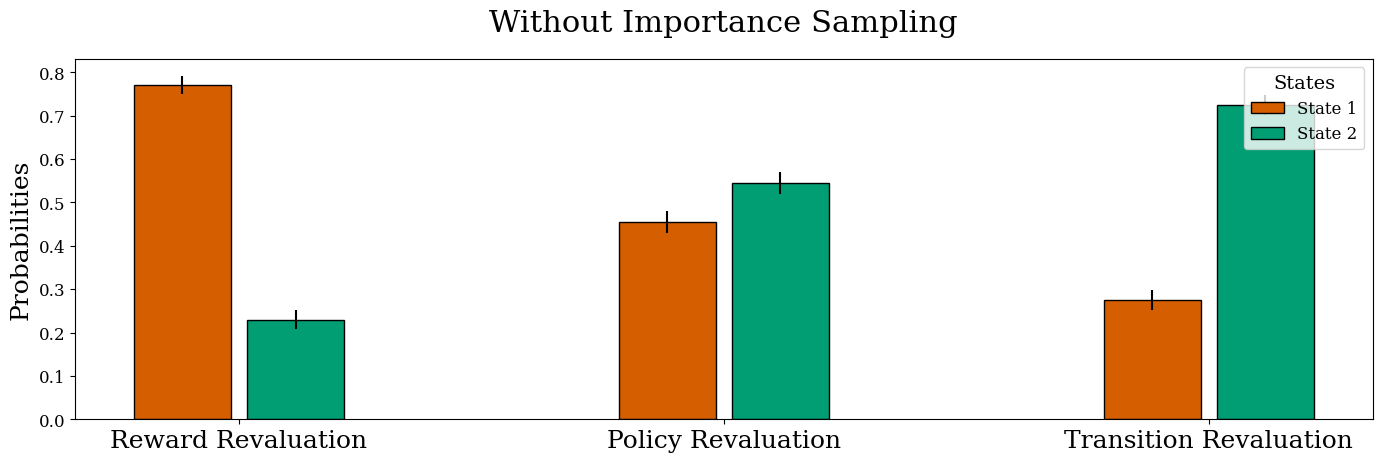

In [24]:
# save_path = save_dir + "nhb_simulations_without.png"
save_path = None

plot_nhb_decisions(
    probs_reward=prob_reward_without,
    probs_policy=prob_policy_without,
    probs_transition=prob_transition_without,
    colors=colors,
    leg_loc='upper right',
    save_path=save_path,
    title='Without Importance Sampling',
    std=[std_reward_without, std_policy_without, std_transition_without]
)

# Plot NHB values against ours

## NHB reconstruction

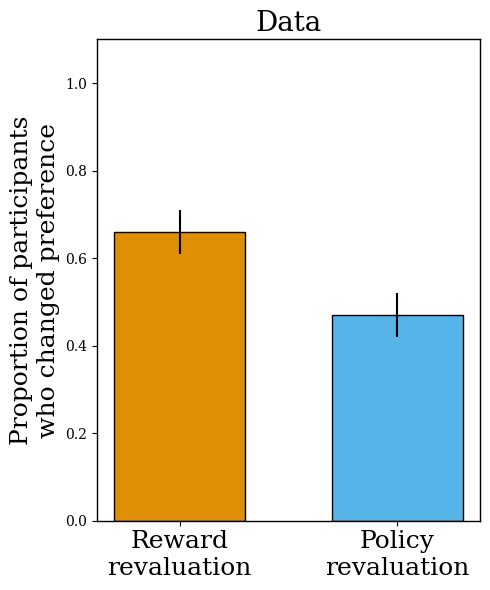

In [44]:
# save_path = save_dir + "NHB_data.png"
save_path = None
nhb_means = [0.66, 0.47]
nhb_stds = [0.05, 0.05]
xlabels = ['Reward\nrevaluation', 'Policy\nrevaluation']
colors = [1, 9]
ylabel = 'Proportion of participants\nwho changed preference'

# Call the function
create_bar_plot(nhb_means, colors, ylabel, xlabels, std=nhb_stds, save_path=save_path, title="Data")

## With Importance Sampling

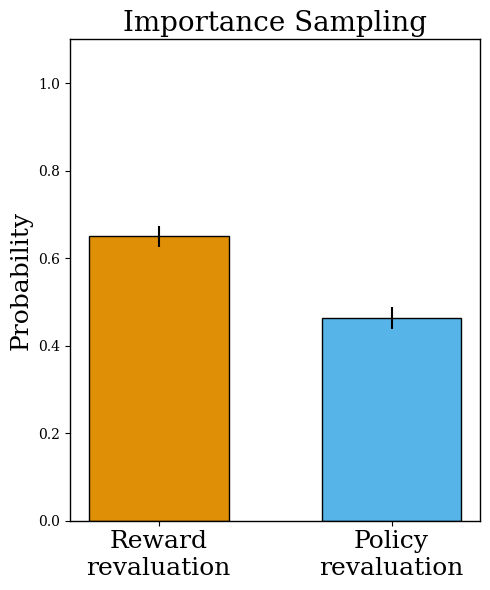

In [45]:
# save_path = save_dir + "NHB_with_imp.png"
save_path = None
means = [prob_reward_with[0], prob_policy_with[0]]
stds = [std_reward_with, std_policy_with]
xlabels = ['Reward\nrevaluation', 'Policy\nrevaluation']
colors = [1, 9]
ylabel = 'Probability'

# Call the function
create_bar_plot(means, colors, ylabel, xlabels, std=stds, save_path=save_path, title="Importance Sampling")

## SR

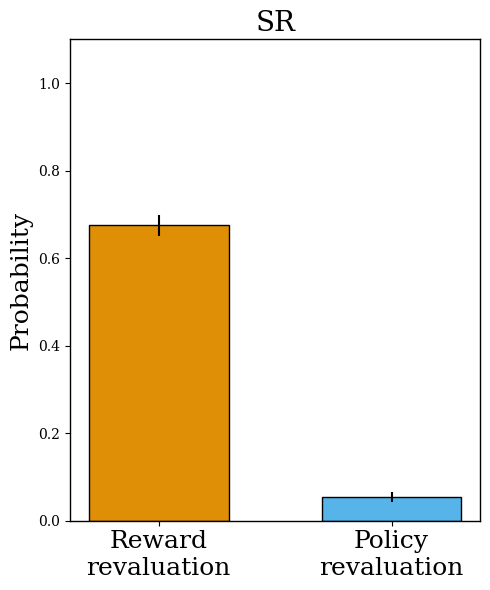

In [46]:
# save_path = save_dir + "NHB_SR.png"
save_path = None
means = [prob_reward_sr[0], prob_policy_sr[0]]
stds = [std_reward_sr, std_policy_sr]
xlabels = ['Reward\nrevaluation', 'Policy\nrevaluation']
colors = [1, 9]
ylabel = 'Probability'

# Call the function
create_bar_plot(means, colors, ylabel, xlabels, std=stds, save_path=save_path, title="SR")

## Complete Model

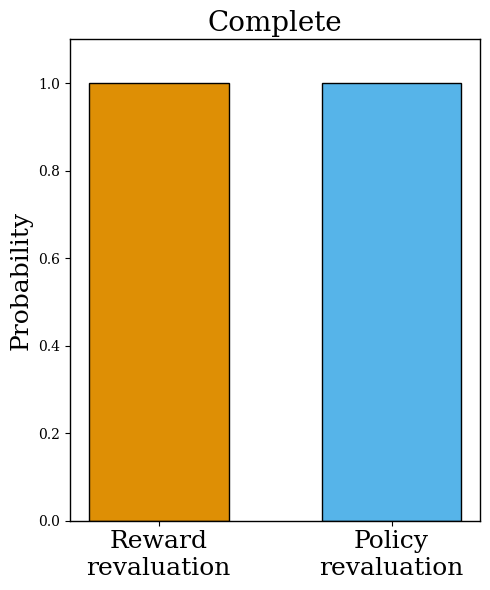

In [47]:
# save_path = save_dir + "NHB_Complete.png"
save_path = None
means = [prob_reward_complete[0], prob_policy_complete[0]]
stds = [std_reward_complete, std_policy_complete]
xlabels = ['Reward\nrevaluation', 'Policy\nrevaluation']
colors = [1, 9]
ylabel = 'Probability'

# Call the function
create_bar_plot(means, colors, ylabel, xlabels, std=stds, save_path=save_path, title="Complete")

<br> <br> <br>

# Supp. Figures contain both with and without importance sampling

## Reward Revaluation

### With importance sampling

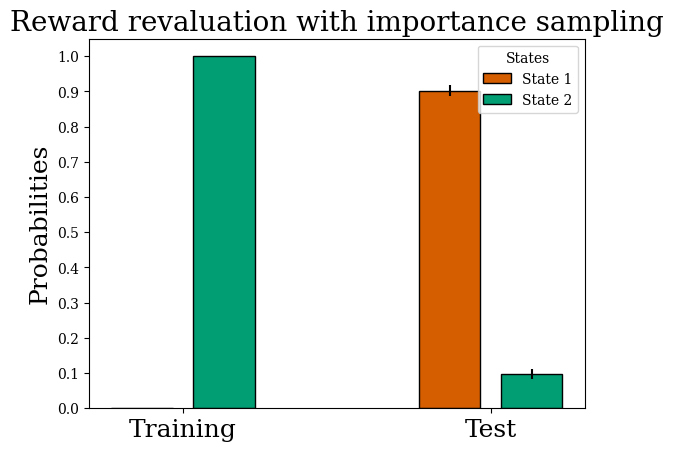

In [30]:
plot_decision_prob(probs_train=prob_reward_with_train, probs_test=prob_reward_with, title="Reward revaluation with importance sampling", 
                   std=[std_reward_with_train, std_reward_with], colors=colors, save_path=None)

### Without importance sampling

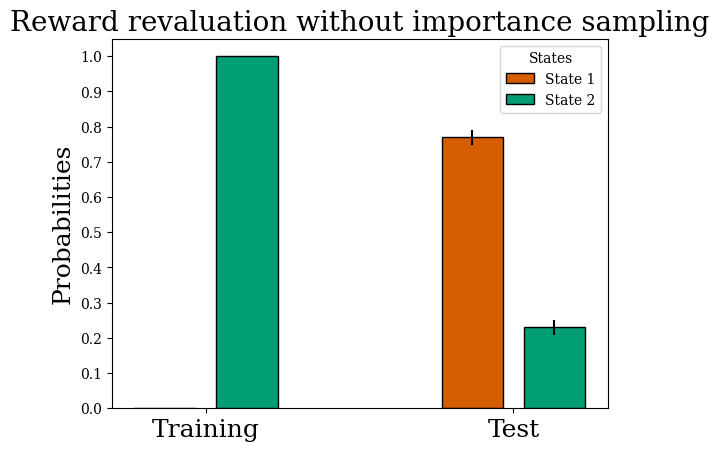

In [31]:
plot_decision_prob(probs_train=prob_reward_without_train, probs_test=prob_reward_without, title="Reward revaluation without importance sampling", 
                   std=[std_reward_without_train, std_reward_without], colors=colors, save_path=None)

## Policy Revaluation

### With importance sampling

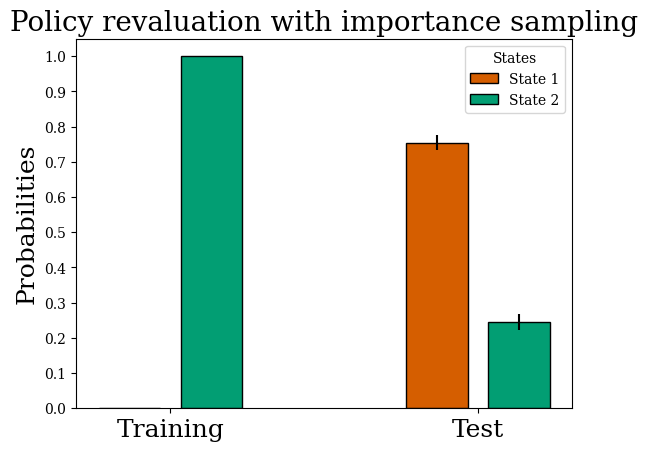

In [32]:
plot_decision_prob(probs_train=prob_policy_with_train, probs_test=prob_policy_with, title="Policy revaluation with importance sampling", 
                   std=[std_policy_with_train, std_policy_with], colors=colors, save_path=None)

### Without importance sampling

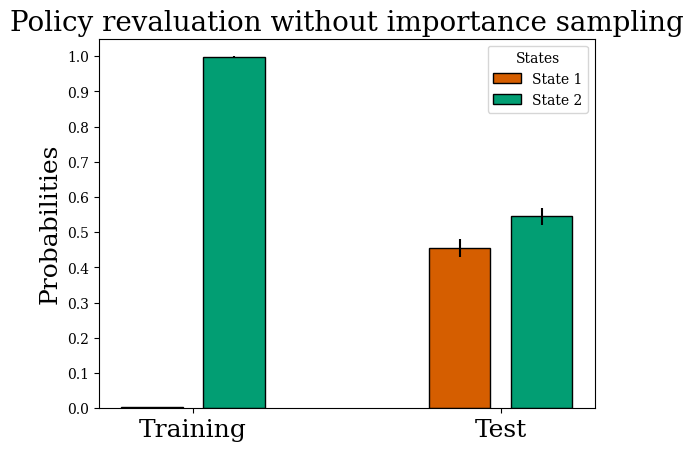

In [33]:
plot_decision_prob(probs_train=prob_policy_without_train, probs_test=prob_policy_without, title="Policy revaluation without importance sampling", 
                   std=[std_policy_without_train, std_policy_without], colors=colors, save_path=None)

## Transition Revaluation

### With importance sampling

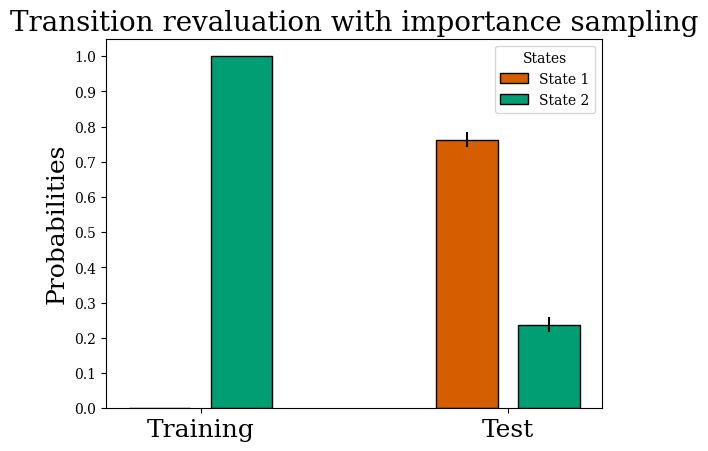

In [34]:
plot_decision_prob(probs_train=prob_transition_with_train, probs_test=prob_transition_with, title="Transition revaluation with importance sampling", 
                   std=[std_transition_with_train, std_transition_with], colors=colors, save_path=None)

### Without importance sampling

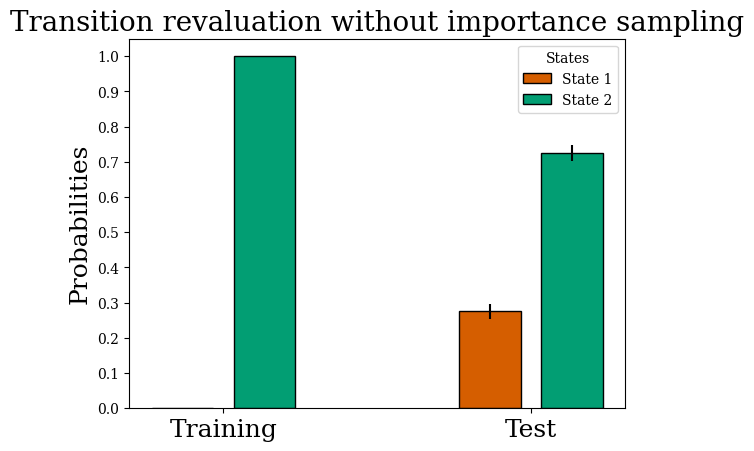

In [35]:
plot_decision_prob(probs_train=prob_transition_without_train, probs_test=prob_transition_without, title="Transition revaluation without importance sampling", 
                   std=[std_transition_without_train, std_transition_without], colors=colors, save_path=None)